In [1]:
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rc('pdf', fonttype=42)

In [3]:
import pandas as pd
import numpy as np

# Timeline

In [97]:
_ = (
    pd.read_csv(
        'rehydrated_tweets_count_by_day.csv',
        parse_dates=['day'],
        index_col=['day', 'lang']
   )
    ['count']
    .unstack('lang', fill_value=0)
)

_['total'] = _.sum(axis=1)
_ = _[['lv', 'ru', 'en', 'total']]

timeline = _[_.index > '2017-04-14']

In [98]:
timeline.head()

lang,lv,ru,en,total
day,,,,
2017-04-15,1297,366,131,1921
2017-04-16,1451,340,182,2178
2017-04-17,1342,289,168,1946
2017-04-18,2722,383,263,3527
2017-04-19,3092,453,280,4031


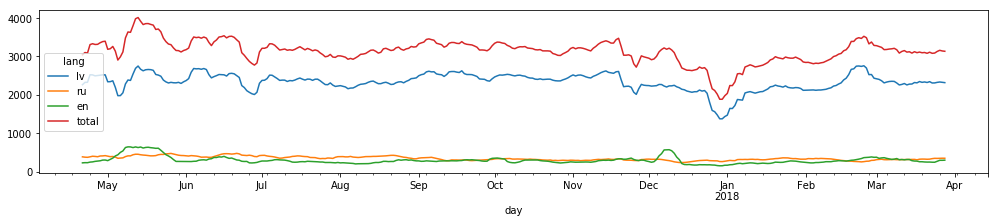

In [106]:
_ = timeline.rolling(window=7).mean().plot(figsize=(17, 3))

_.figure.savefig('rehydrated_tweets_count_by_day.pdf')

# Language usage 

In [134]:
_ = pd.read_csv('rehydrated_tweets_lang_usage.csv', index_col='rnum')

_['Language Uniformity Score'] = (_[['lv', 'ru', 'en']].max(axis=1) / _[['lv', 'ru', 'en']].sum(axis=1)).round(2)

lang_usage = _

In [135]:
lang_usage.head()

,lv,ru,en,total,Language Uniformity Score
rnum,,,,,
1,26403,0,13,26478,1.0
2,21989,0,3,22046,1.0
3,20189,0,0,20246,1.0
4,17496,0,15,17619,1.0
5,15757,0,14,15885,1.0


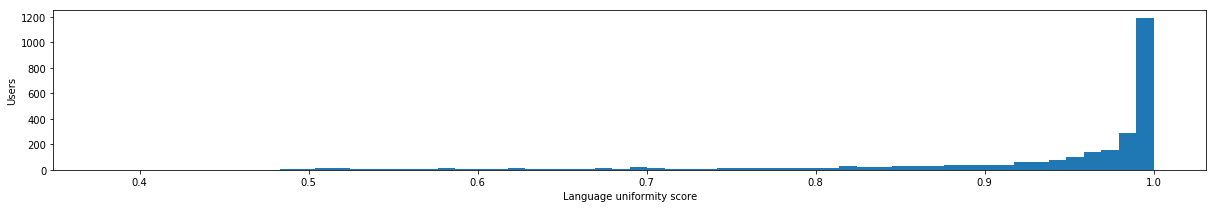

In [136]:
_ = lang_usage['Language Uniformity Score'].plot.hist(bins=60, figsize=(17, 3))

_.set(xlabel="Language uniformity score", ylabel="Users")
_.figure.tight_layout()

_.figure.savefig('rehydrated_tweets_lang_usage.pdf')

In [137]:
lang_usage[lang_usage['Language Uniformity Score'] < 0.5].sort_values('Language Uniformity Score')

,lv,ru,en,total,Language Uniformity Score
rnum,,,,,
359,105,147,133,557,0.38
1211,23,31,23,140,0.40
737,70,75,40,247,0.41
1145,19,39,38,148,0.41
1402,36,34,13,117,0.43
1959,20,15,12,77,0.43
760,87,25,91,238,0.45
1473,15,16,27,110,0.47
1874,30,6,28,81,0.47
